# Simple FEM for one dimensional Burgers' equation

The problem for $u(t,x)$ is stated as
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \nu \frac{\partial^2 u}{\partial x^2} = 0 \quad \text{for} \quad x \in [-1,1] , t \in [0, 0.5]
$$
with $\nu=\frac{0.01}{\pi}$ subject to the boundary condition
$$
u(t, x=0) = 0
$$
and the initial condition
$$
u(t=0, x) = -\sin(\pi x)
$$

The problem is inspired by https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/burgers.html.

In [1]:
import deepxde as dde 
import matplotlib.pyplot as plt 
import numpy as np

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Spacial and time domains

We represent the inner points in space and time by a set of collocation points.

In [2]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)

## Train the PINN 
We adjust the weights such that the loss is minimized over several epochs.

Compiling model...
'compile' took 0.149170 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.50e-05, 1.19e-02, 5.85e-01]    [4.50e-05, 1.19e-02, 5.85e-01]    []  
1000      [1.09e-02, 9.55e-04, 2.38e-02]    [1.09e-02, 9.55e-04, 2.38e-02]    []  
2000      [4.30e-03, 1.48e-04, 1.55e-02]    [4.30e-03, 1.48e-04, 1.55e-02]    []  
3000      [2.99e-03, 1.20e-04, 1.20e-02]    [2.99e-03, 1.20e-04, 1.20e-02]    []  
4000      [2.24e-03, 2.45e-05, 1.07e-02]    [2.24e-03, 2.45e-05, 1.07e-02]    []  
5000      [1.93e-03, 8.32e-06, 9.49e-03]    [1.93e-03, 8.32e-06, 9.49e-03]    []  
6000      [2.00e-03, 4.52e-05, 8.32e-03]    [2.00e-03, 4.52e-05, 8.32e-03]    []  
7000      [1.64e-03, 1.17e-05, 7.56e-03]    [1.64e-03, 1.17e-05, 7.56e-03]    []  
8000      [1.24e-03, 7.70e-06, 5.59e-03]    [1.24e-03, 7.70e-06, 5.59e-03]    []  
9000      [9.06e-04, 1.09e-05, 2.77e-03]    [9.06e-04, 1.09e-05, 2.77e-03]    []  
10000     [7.23

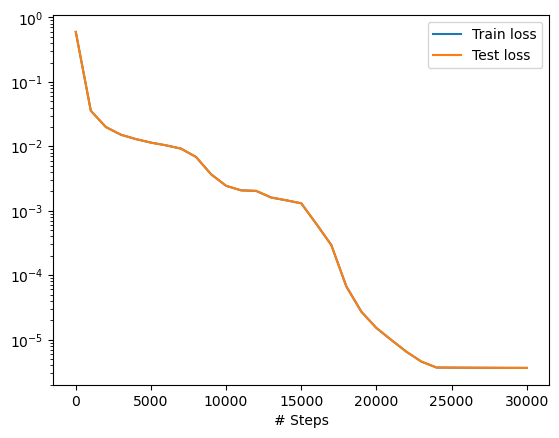

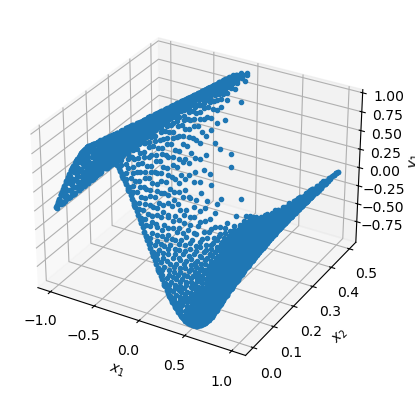

In [3]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

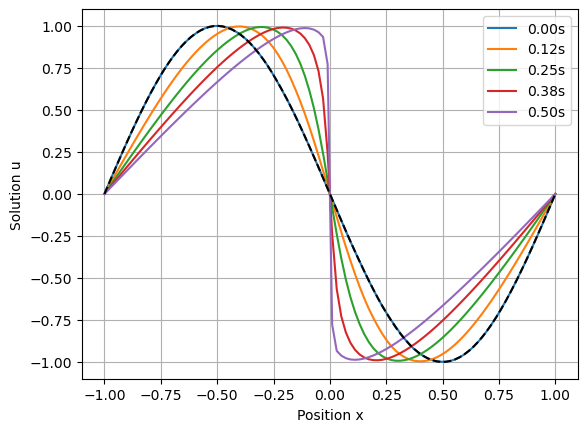

In [4]:
# Plot results
for i in range(5):
    val_x = np.linspace(-1, 1, 100)
    val_t = 0.1 * i * np.ones_like(val_x)
    val = np.vstack((np.ravel(val_x), np.ravel(val_t))).T
    u_v = model.predict(val)
    plt.plot(val_x, u_v)
plt.plot(val_x, -np.sin(np.pi*val_x), "--k")
plt.legend([f"{t:.2f}s" for t in np.linspace(0, 0.5, 5) ])
plt.xlabel("Position x")
plt.ylabel("Solution u")
plt.grid()
plt.show()